In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [6]:
class TweetClassificationModel:
    def __init__(self, data_file):
        # Load the dataset
        self.df = pd.read_csv(data_file)
        self.df = self.df.drop_duplicates('Tweet', keep='first')
        self.df['Tweet'].count()
        self.df["Cleaned_Tweet"] = [re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", "", v.lower()) for v in self.df["Tweet"]]
        self.df.drop('Tweet', axis=1, inplace=True)
        vals_to_replace = {'Relevant': 1, 'Not Relevant': 0}
        self.df['Category'] = self.df['Category'].map(vals_to_replace)
        self.df.dropna(inplace=True)
        self.df['Category'].unique()

        # Train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df['Cleaned_Tweet'], self.df['Category'], test_size=0.2, random_state=42)

        # Initialize Tokenizer
        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(self.X_train)
        self.max_sequence_length = 100

    def preprocess_data(self):
        # Tokenize and pad the sequences
        X_train_sequences = self.tokenizer.texts_to_sequences(self.X_train)
        X_test_sequences = self.tokenizer.texts_to_sequences(self.X_test)
        self.X_train_padded = pad_sequences(X_train_sequences, maxlen=self.max_sequence_length)
        self.X_test_padded = pad_sequences(X_test_sequences, maxlen=self.max_sequence_length)

    def build_model(self):
        # Build the LSTM model
        self.model = Sequential()
        self.model.add(Embedding(len(self.tokenizer.word_index) + 1, 32, input_length=self.max_sequence_length))
        self.model.add(LSTM(64, return_sequences=True))
        self.model.add(LSTM(64))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    def train_model(self, epochs=5, batch_size=32):
        # Train the LSTM model
        self.model.fit(self.X_train_padded, self.y_train, validation_data=(self.X_test_padded, self.y_test), epochs=epochs, batch_size=batch_size)

    def evaluate_model(self):
        # Evaluate the model on the test set
        y_pred = self.model.predict(self.X_test_padded)
        auc = roc_auc_score(self.y_test, y_pred)
        print("AUC:", auc)
        return y_pred  # Return y_pred for later use in plot_roc_curve

    def plot_roc_curve(self, y_pred):
        # Plot the ROC curve
        auc = roc_auc_score(self.y_test, y_pred)
        fpr, tpr, thresholds = roc_curve(self.y_test, y_pred)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.legend(loc="lower right")
        plt.show()

Epoch 1/5
254/254 [==============================] - 25s 80ms/step - loss: 0.5321 - accuracy: 0.7331 - val_loss: 0.4632 - val_accuracy: 0.7975
Epoch 2/5
254/254 [==============================] - 19s 74ms/step - loss: 0.3230 - accuracy: 0.8687 - val_loss: 0.4769 - val_accuracy: 0.7891
Epoch 3/5
254/254 [==============================] - 19s 75ms/step - loss: 0.2073 - accuracy: 0.9221 - val_loss: 0.5185 - val_accuracy: 0.7941
Epoch 4/5
254/254 [==============================] - 19s 74ms/step - loss: 0.1481 - accuracy: 0.9505 - val_loss: 0.5409 - val_accuracy: 0.7714
Epoch 5/5
64/64 [==============================] - 2s 24ms/step
AUC: 0.8438156249499046


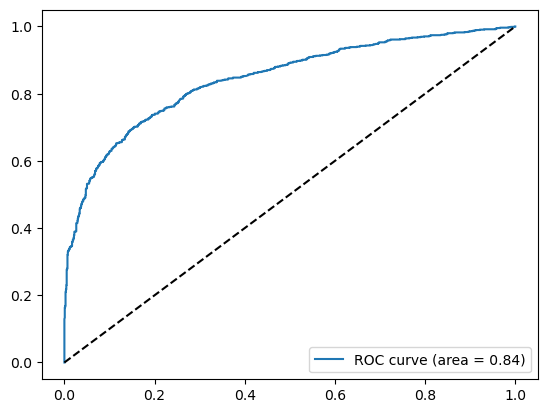

In [7]:
if __name__ == "__main__":
    data_file = 'D:\study\group3.csv'
    model = TweetClassificationModel(data_file)
    model.preprocess_data()
    model.build_model()
    model.train_model()
    y_pred = model.evaluate_model()
    model.plot_roc_curve(y_pred)

In [ ]:
#HyperParameterTuning